In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

In [ ]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_unknown
from New_kernel_1 import Discontinuous_Dirichlet
from New_kernel_1 import Discontinuous_Poisson

from Poisson_Process import Poisson_Process

#from Dirichlet import Dirichlet_Process

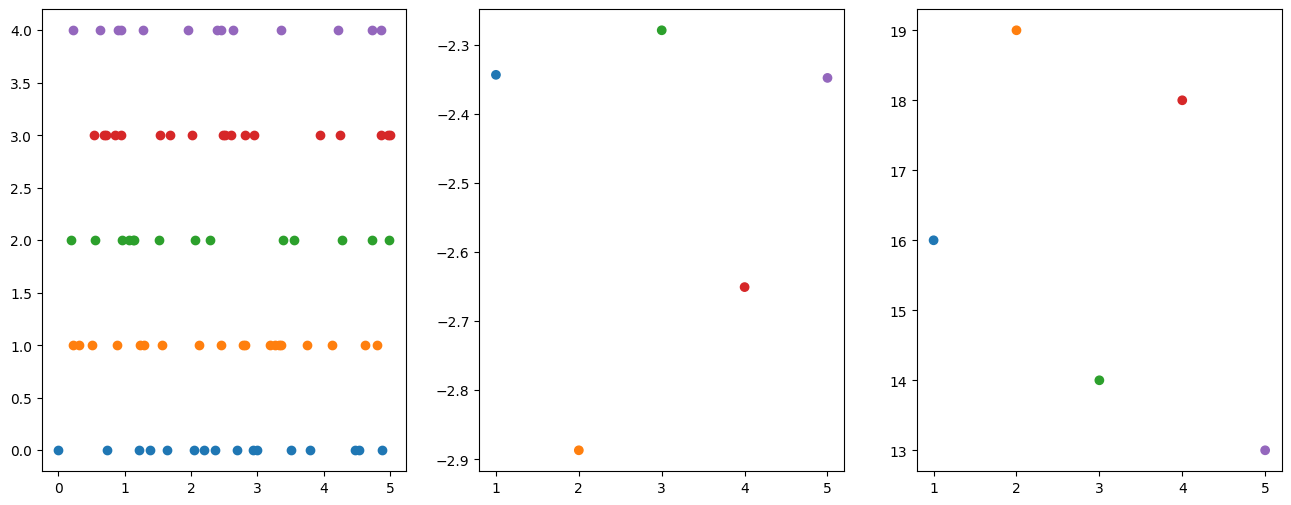

In [ ]:
import matplotlib.colors as cm
scale = 1/3
size = 20
T = 5
PP = Poisson_Process(scale, size, T)


num_samples = 5
colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_samples)]
key = jrnd.PRNGKey(12345)

key, subkey = jax.random.split(key)
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
theta = PP._sample_n(subkey, num_samples)
prob = jnp.zeros(num_samples)


for i, c in zip(range(num_samples), colors):
    sort_x = jnp.sort(theta[i, :], axis=0)
    indices = jnp.argsort(theta[i, :], axis = 0)
    prob = prob.at[i].set(PP.log_prob(theta[i]))
    length = jnp.sum(~jnp.isnan(sort_x))
    ax[0].scatter(sort_x[:length], jnp.zeros(length)+i, color = c)

ax[1].scatter(jnp.arange(1, num_samples+1), prob, c=colors)
ax[2].scatter(jnp.arange(1, num_samples+1), jnp.sum(~jnp.isnan(theta), axis = 1), c=colors)


plt.show()

(49724,)


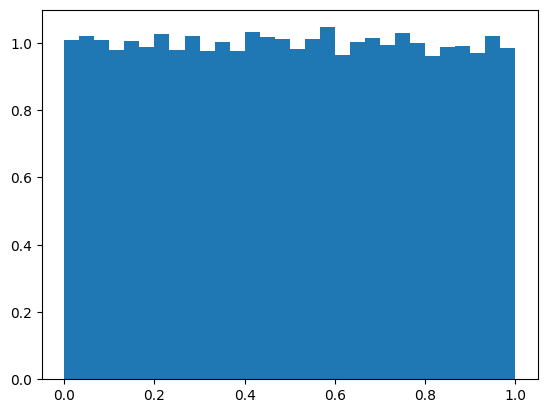

In [ ]:
scale = 1/5
size = 10
T = 1
PP = Poisson_Process(scale, size, T)

num_samples = 10000
theta = PP._sample_n(subkey, num_samples)
# print(theta.shape)
new_theta, _ = jax.flatten_util.ravel_pytree(theta)
new_theta = new_theta[~jnp.isnan(new_theta)]
# print(new_theta.shape)
# new_theta = jnp.flatten(theta)

plt.hist(new_theta, bins = 30, density = True)
plt.show()

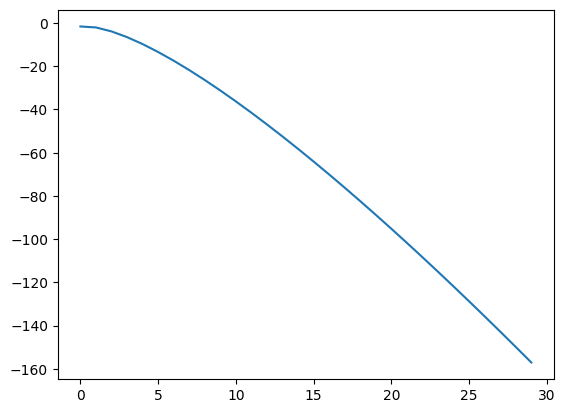

In [ ]:
scale = 2.5
size = 100
T = 2
vals = 30

log_probs = jnp.zeros(vals)

PP = Poisson_Process(scale, size, T)
for i in range(vals):
  # print(PP.log_prob(jnp.ones(vals)))
  log_probs = log_probs.at[i].set(PP.log_prob(jnp.ones(i)))

plt.plot(log_probs)



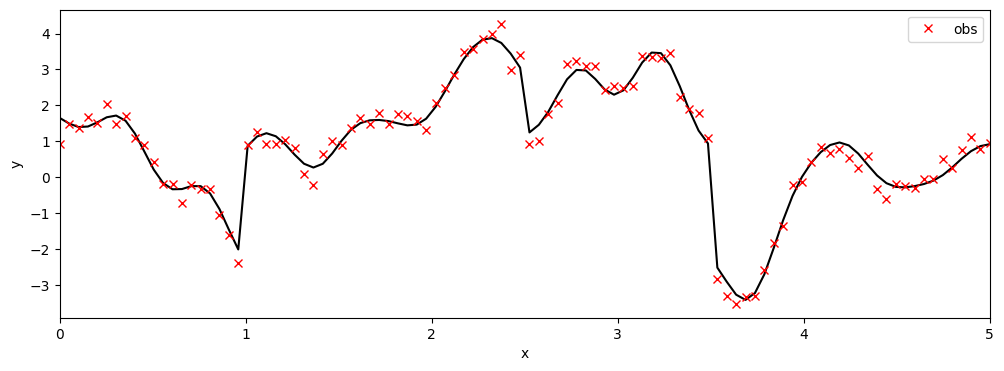

In [ ]:
key = jrnd.PRNGKey(12345)

T = 5
lengthscale_ = 0.2
output_scale_ = 3.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, T, n)[:, jnp.newaxis]

x0 = jnp.array([0.2, 0.5, 0.7])*T
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., T])
plt.legend();

In [ ]:
scale = T/len(x0)
size = 20
base_kernel = jk.RBF()
kernel = Discontinuous_Poisson(base_kernel)
# p = jnp.zeros(num_CP+1)+(1/(num_CP+1))

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=Poisson_Process(scale, size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [ ]:
sample_pp = Poisson_Process(1/3, 100, 1)
#key, new_key = jrnd.split(key)
key = jax.random.PRNGKey(42)
cps = jnp.squeeze(sample_pp._sample_n(key, 1))
# print(cps[0:5])
for scale in jnp.linspace(0.1, 2.5, num=30):
  pp = Poisson_Process(scale, 100, 1)
  # print([scale, pp.log_prob(cps)])


In [ ]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 44.5 s, sys: 30.8 s, total: 1min 15s
Wall time: 1min 15s


In [ ]:
%%time

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 1min 58s, sys: 193 ms, total: 1min 58s
Wall time: 1min 59s


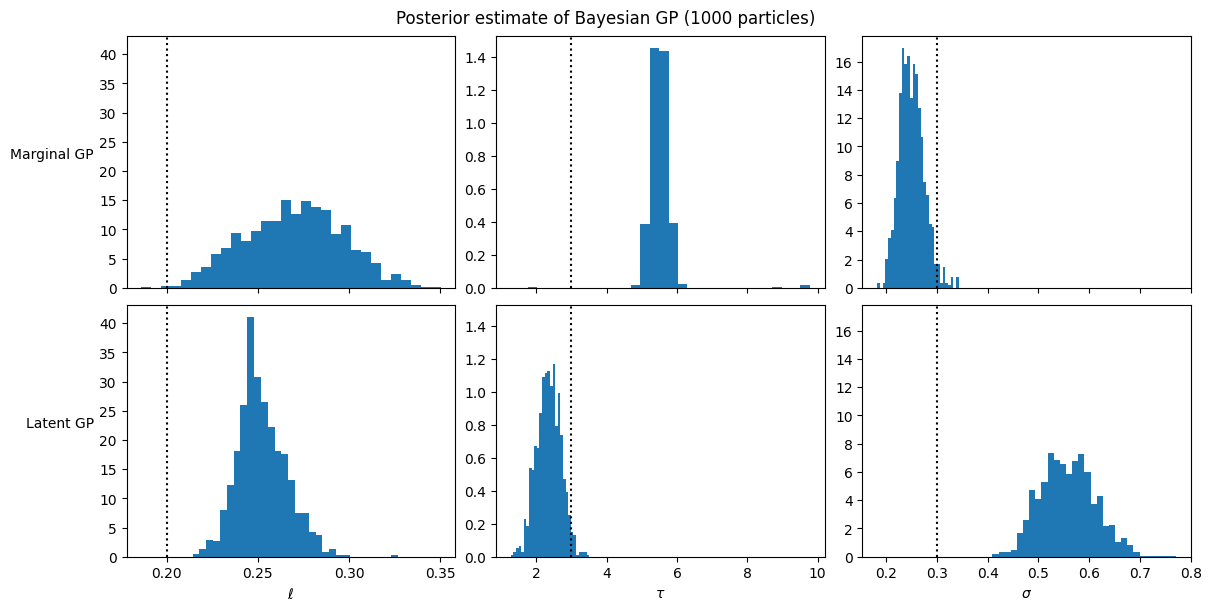

In [ ]:
trainables = ['lengthscale', 'variance', 'obs_noise']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau')

_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                    sharex='col', sharey='col', figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            obs_noise=particles.particles['likelihood']['obs_noise'])
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axes
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        ax.axvline(x=ground_truth[var], ls=':', c='k')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right');

CPU times: user 10.7 s, sys: 1.58 s, total: 12.3 s
Wall time: 11.8 s


Text(0, 0.5, 'Latent GP')

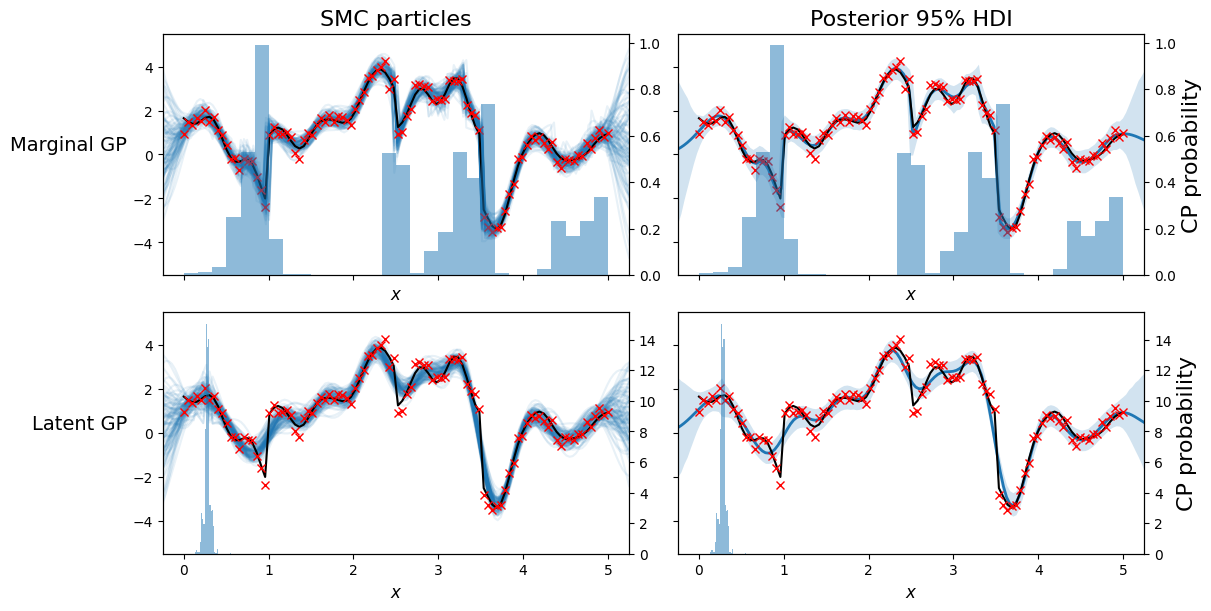

In [ ]:
%%time

x_pred = jnp.linspace(-0.25, T+.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = particles.particles['kernel']['num']
    # There are some outliers that skew the axis
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
    ax2 = ax.twinx()
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    #print(new_pd.shape)

    ax2 = ax.twinx()
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, T+.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0, 0].set_title('SMC particles', fontsize=16)
axes[0, 1].set_title('Posterior 95% HDI', fontsize=16)

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14);

(1000,)
(1000,)


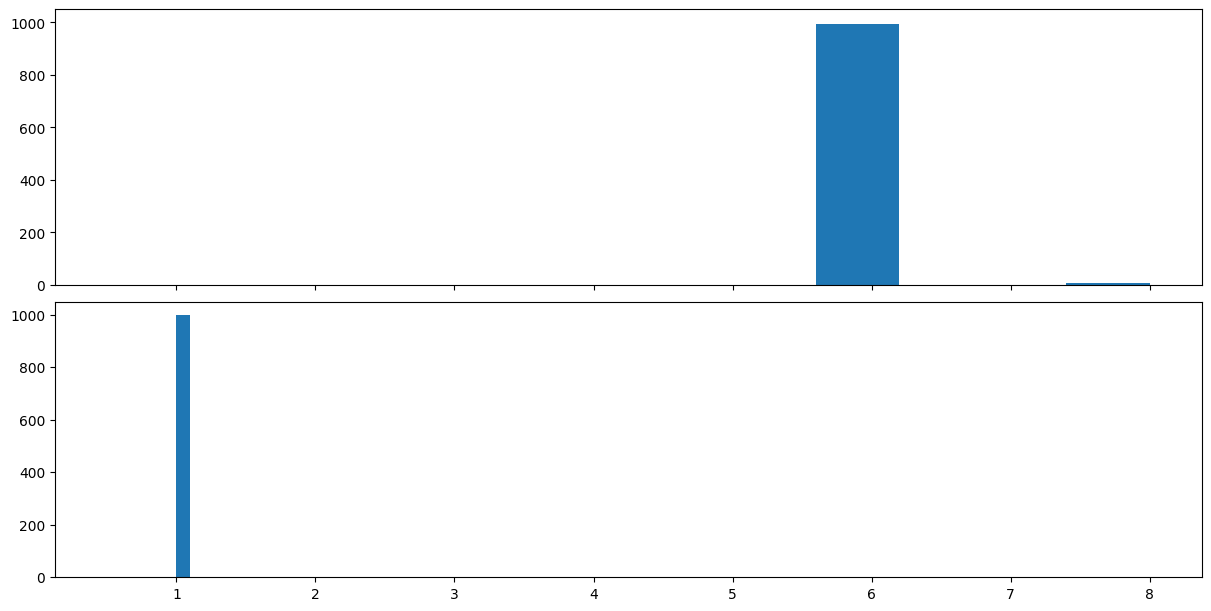

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)

    num_val = particles.particles['kernel']['num']
    counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
    print(counts.shape)
    #uni_vals = len(jnp.unique(num_val))
    axes[j].hist(counts, bins=10)

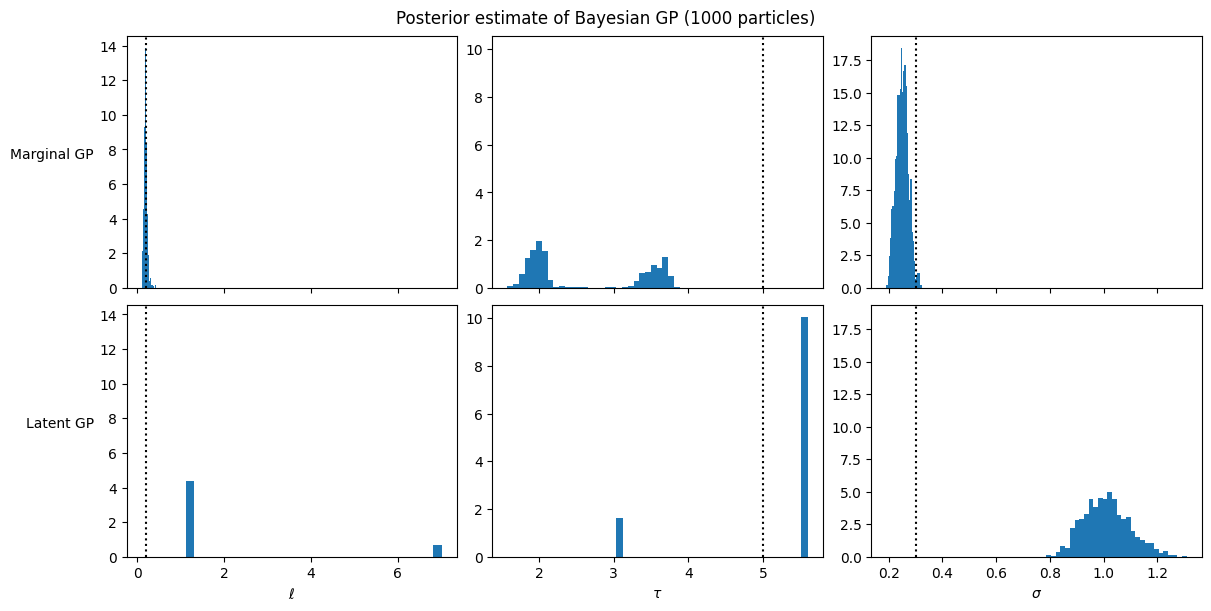

In [ ]:
trainables = ['lengthscale', 'variance', 'obs_noise']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau')

_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                    sharex='col', sharey='col', figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            obs_noise=particles.particles['likelihood']['obs_noise'])
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axes
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        ax.axvline(x=ground_truth[var], ls=':', c='k')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right');

CPU times: user 9.61 s, sys: 1.44 s, total: 11.1 s
Wall time: 10.1 s


Text(0, 0.5, 'Latent GP')

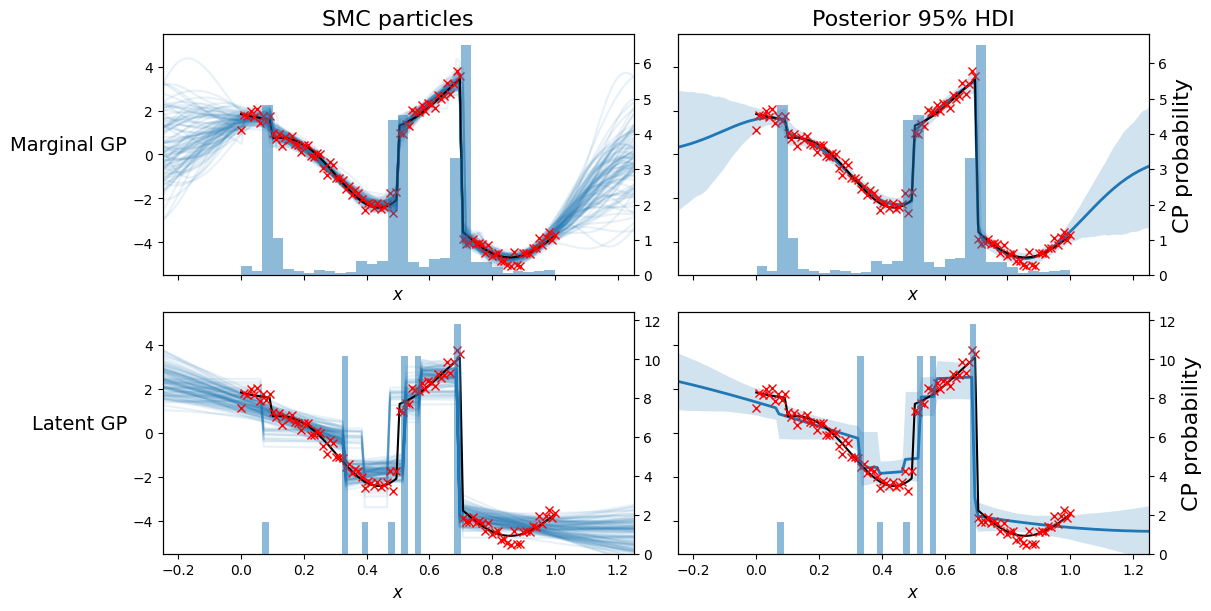

In [ ]:
%%time

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = particles.particles['kernel']['num']
    # There are some outliers that skew the axis
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
    ax2 = ax.twinx()
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    #print(new_pd.shape)

    ax2 = ax.twinx()
    ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0, 0].set_title('SMC particles', fontsize=16)
axes[0, 1].set_title('Posterior 95% HDI', fontsize=16)

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14);

(1000,)
(1000,)


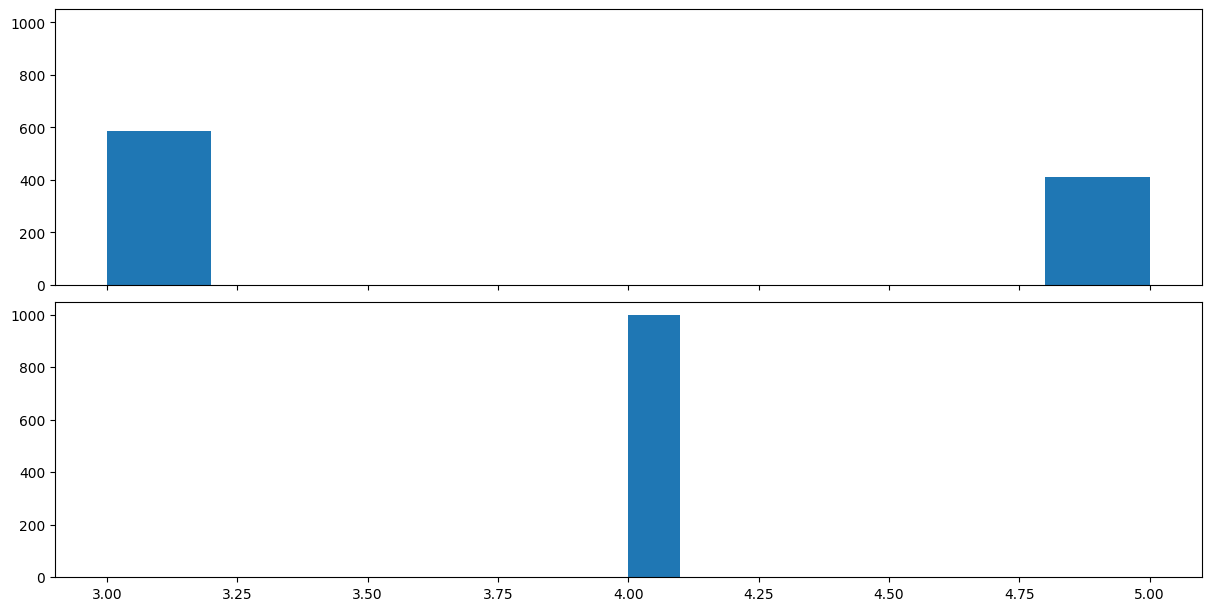

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)

    num_val = particles.particles['kernel']['num']
    counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
    print(counts.shape)
    #uni_vals = len(jnp.unique(num_val))
    axes[j].hist(counts, bins=10)

Testing Poisson Process with hyperparameter
---



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_unknown
from New_kernel_1 import Discontinuous_Dirichlet
from New_kernel_1 import Discontinuous_Poisson

from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper

Testing for many changepoints (7)

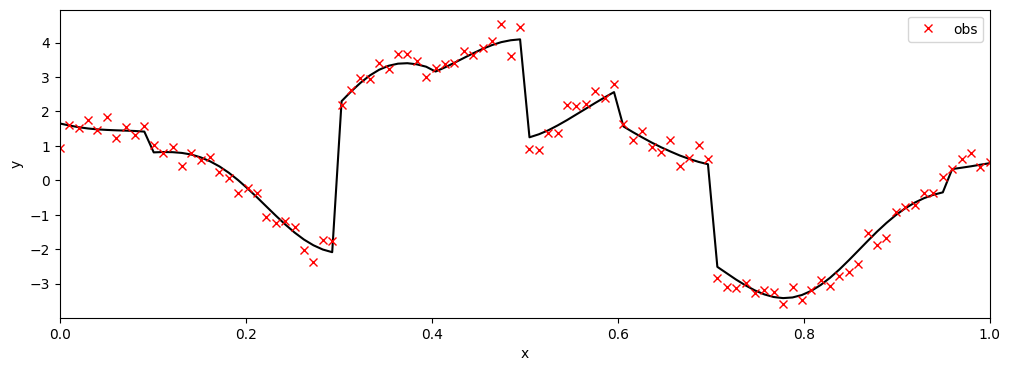

In [ ]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.1
output_scale_ = 3.0
obs_noise_ = 0.3
n = 100
T = 1.
x = jnp.linspace(0, T, n)[:, jnp.newaxis]

x0 = jnp.array([10, 30, 70, 40, 60, 50, 95])/(100)*T
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_,
                    alpha=T/len(x0))

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., T])
plt.legend();

In [ ]:
size = 20
base_kernel = jk.RBF()
kernel = Discontinuous_Poisson(base_kernel)
# p = jnp.zeros(num_CP+1)+(1/(num_CP+1))

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_marginal = FullMarginalGPModelhyper(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [ ]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 51.7 s, sys: 38.8 s, total: 1min 30s
Wall time: 1min 34s


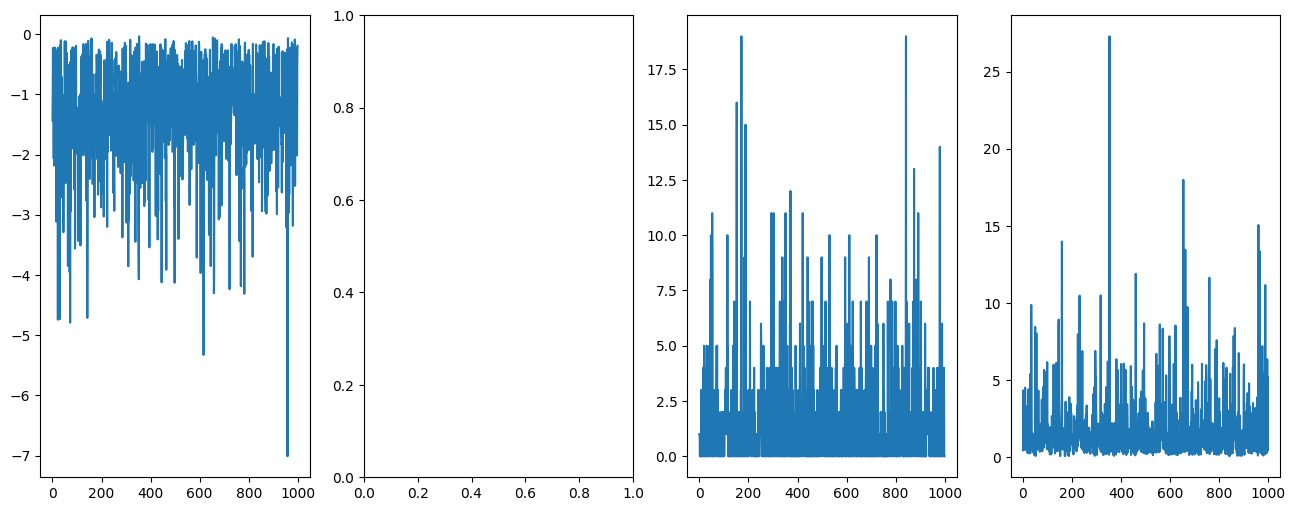

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (16, 6))

#samples = gp_marginal.get_monte_carlo_samples()

size = 20
PP = Poisson_Process_hyper(size, T)
state = gp_marginal.init_fn(key, num_particles)
samples = getattr(state, 'position', state)
log_pr = gp_marginal.logprior_fn()
pr = log_pr(state)

log_probs = jnp.zeros(num_particles)
lengths = jnp.zeros(num_particles)
alphas = jnp.zeros(num_particles)

for i in range(num_particles):
  log_probs = log_probs.at[i].set(PP.log_prob(samples['kernel']['num'][i, :], samples['hyper']['hyper_pp'][i]))
  lengths = lengths.at[i].set(len(samples['kernel']['num'][i, ~jnp.isnan(samples['kernel']['num'][i, :])]))

axes[0].plot(log_probs)
#axes[1].plot(temp)
axes[2].plot(lengths)
axes[3].plot(samples['hyper']['hyper_pp'])

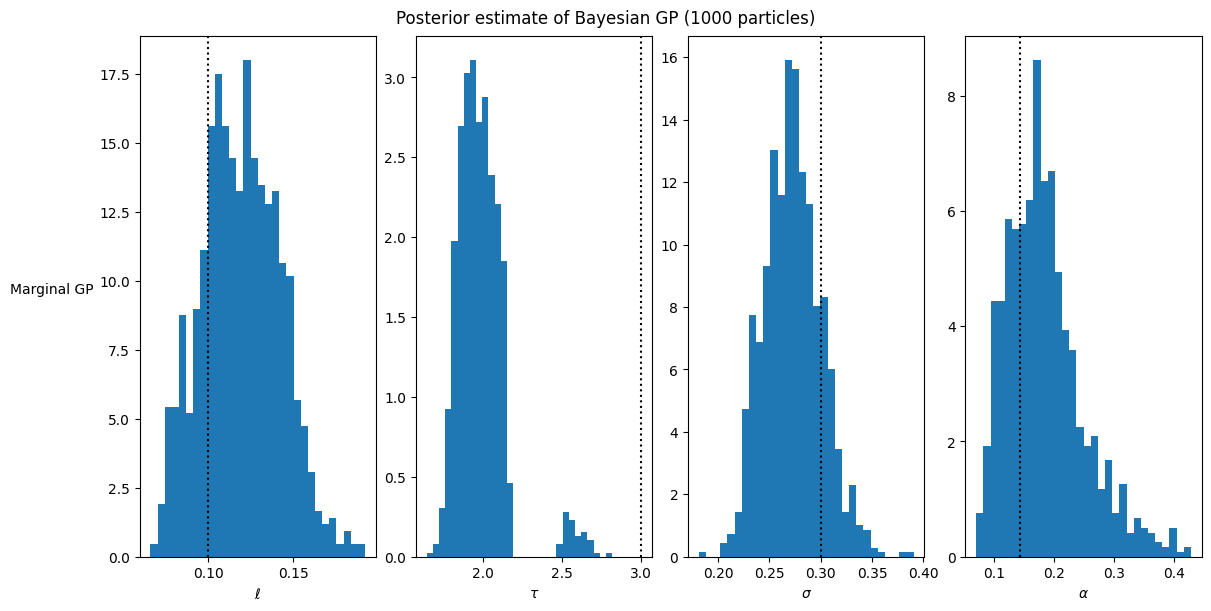

In [ ]:
trainables = ['lengthscale', 'variance', 'obs_noise', 'alpha']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau',
               alpha=r'\alpha')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                    sharex="col", sharey=False, figsize=(12, 6))

particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
        variance=particles.particles['kernel']['variance'],
        obs_noise=particles.particles['likelihood']['obs_noise'],
        alpha=particles.particles['hyper']['hyper_pp'])
for j, var in enumerate(trainables):
    ax = axes[j]
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    ax.hist(pd, bins=30, density=True, color='tab:blue')
    ax.axvline(x=ground_truth[var], ls=':', c='k')
    if var in symbols:
        ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right')
plt.show()

Text(0, 0.5, 'Marginal GP')

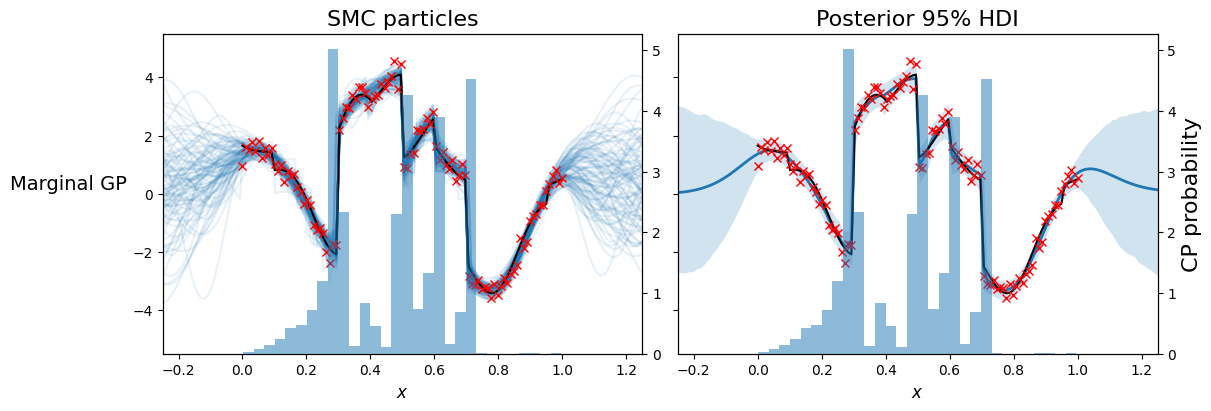

In [ ]:
x_pred = jnp.linspace(-0.25, T+.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, T+.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

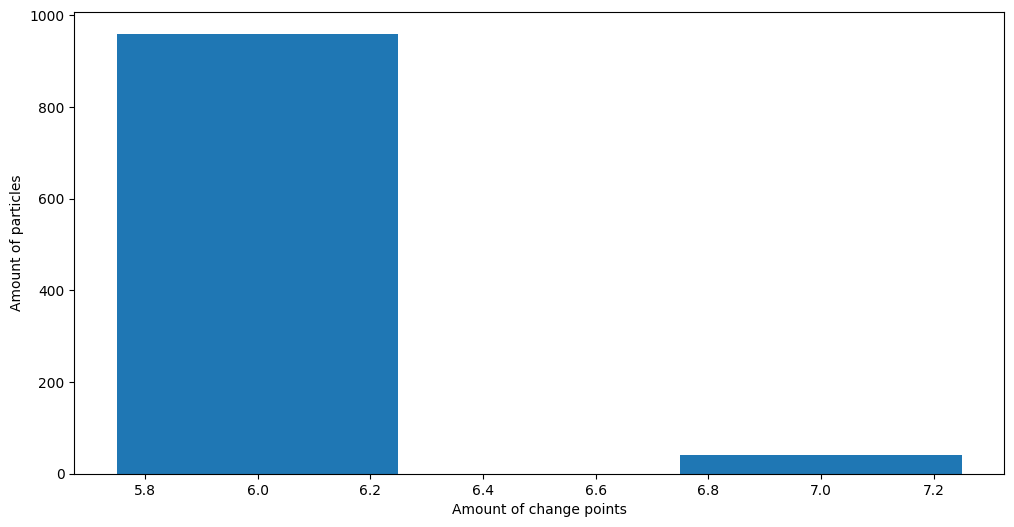

In [ ]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()

Testing for 3 change points

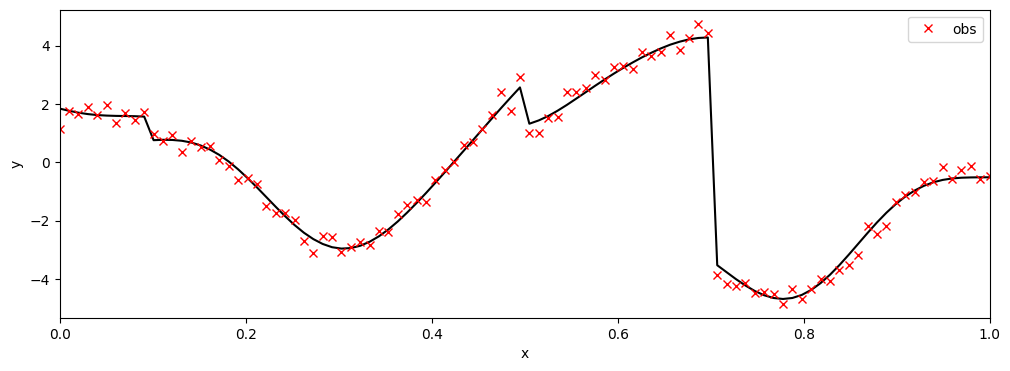

In [ ]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.1
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
T = 1.
x = jnp.linspace(0, T, n)[:, jnp.newaxis]

x0 = jnp.array([10, 50, 70])/(100)*T
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_,
                    alpha=T/len(x0))

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., T])
plt.legend();

In [ ]:
size = 20
base_kernel = jk.RBF()
kernel = Discontinuous_Poisson(base_kernel)
# p = jnp.zeros(num_CP+1)+(1/(num_CP+1))

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_marginal = FullMarginalGPModelhyper(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [ ]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 52.9 s, sys: 39.7 s, total: 1min 32s
Wall time: 1min 32s


Text(0, 0.5, 'Marginal GP')

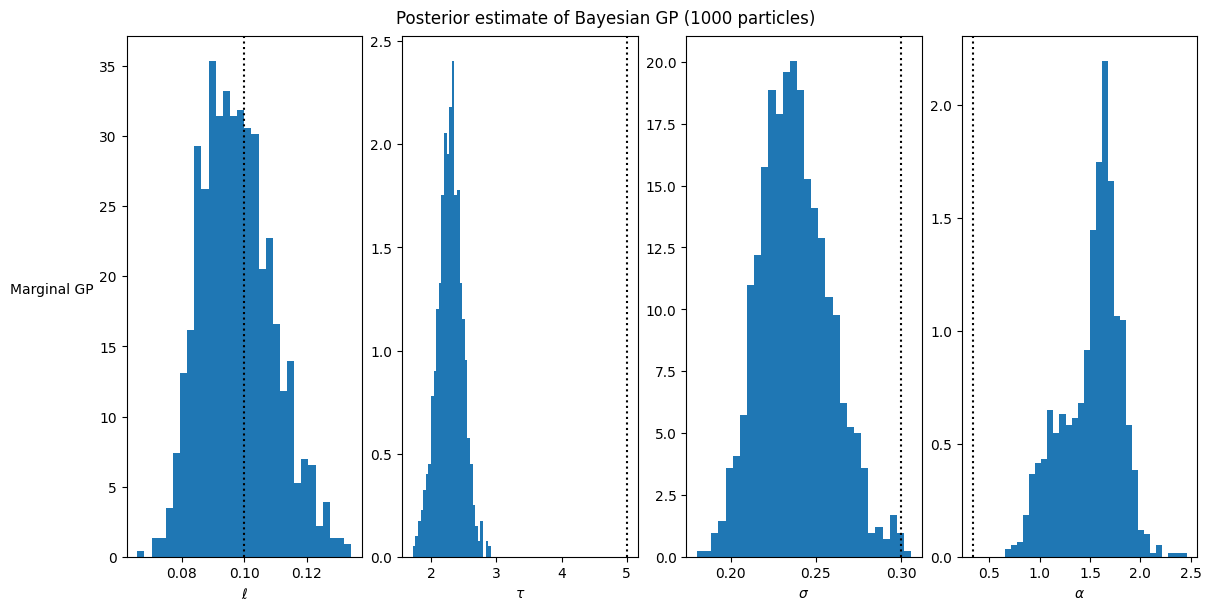

In [ ]:
trainables = ['lengthscale', 'variance', 'obs_noise', 'alpha']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau',
               alpha=r'\alpha')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                    sharex="col", sharey=False, figsize=(12, 6))

particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
        variance=particles.particles['kernel']['variance'],
        obs_noise=particles.particles['likelihood']['obs_noise'],
        alpha=particles.particles['hyper']['hyper_pp'])
for j, var in enumerate(trainables):
    ax = axes[j]
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    ax.hist(pd, bins=30, density=True, color='tab:blue')
    ax.axvline(x=ground_truth[var], ls=':', c='k')
    if var in symbols:
        ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right')
#axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')
#plt.savefig("parameter_post_easy.png")
#files.download("parameter_post_easy.png")

Text(0, 0.5, 'Marginal GP')

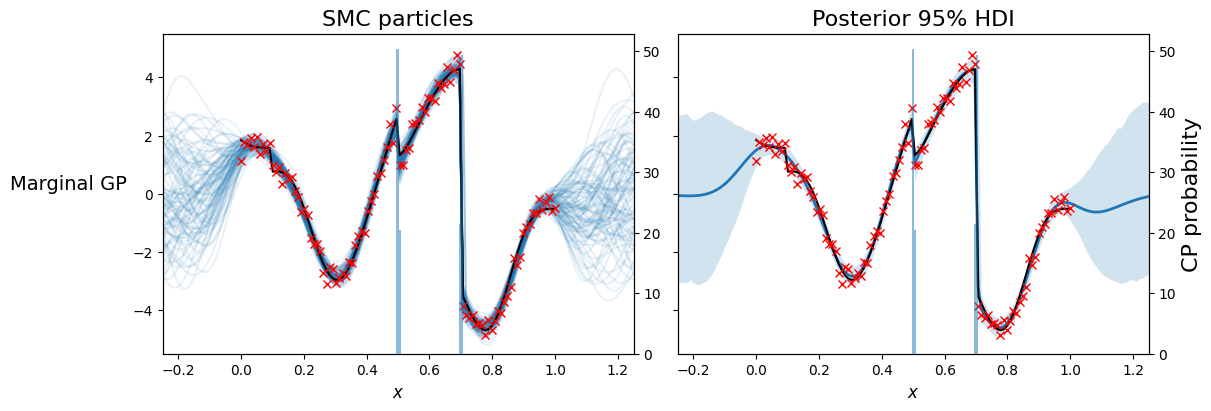

In [ ]:
x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

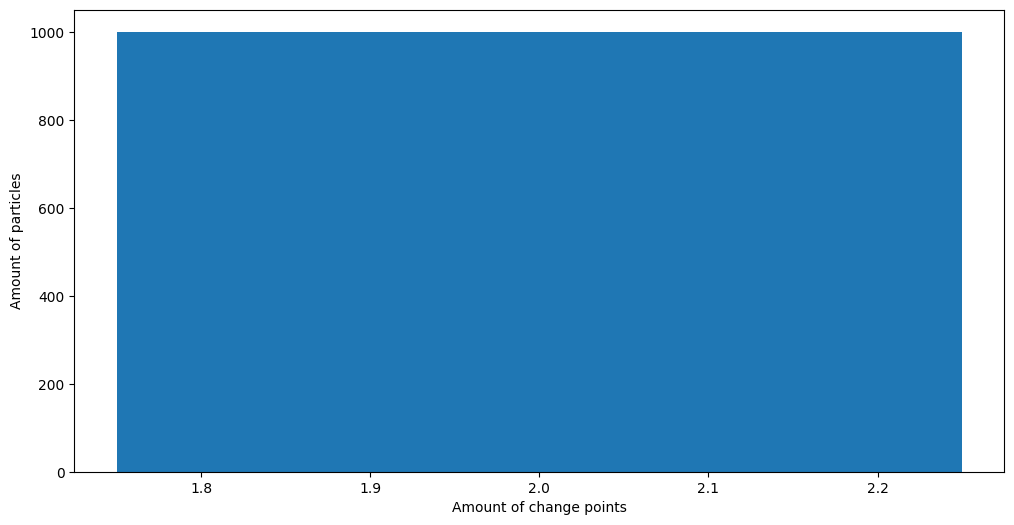

In [ ]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()

Testing for 1 change point in 5 seconds (rate = 1/2, scale = 2)

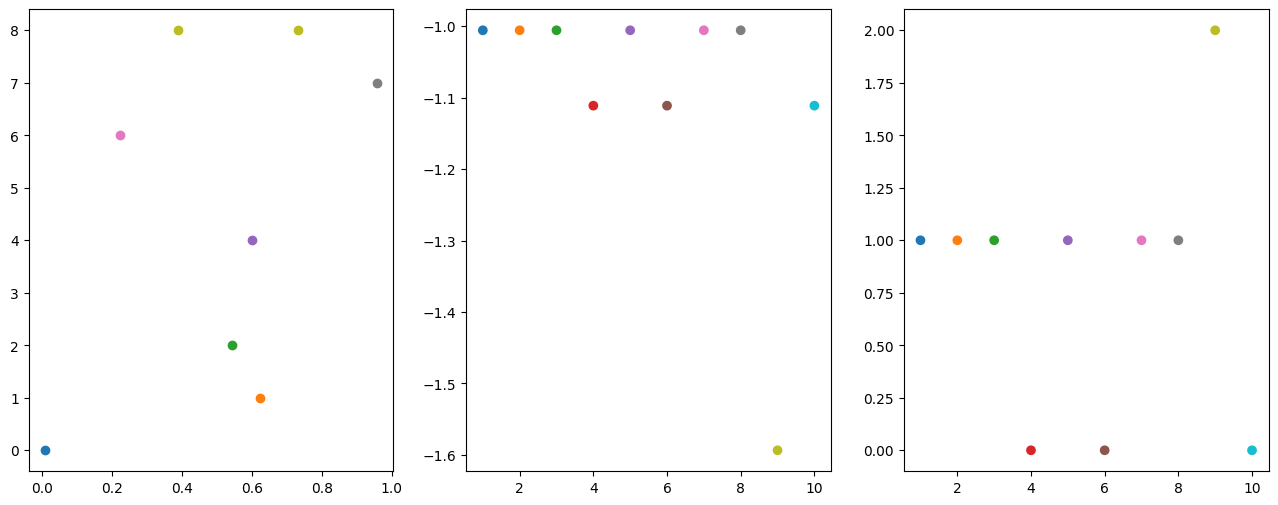

In [ ]:
import matplotlib.colors as cm

alpha = 0.9
num_samples = 10
T = 1
PP_test = Poisson_Process_hyper(num_samples, T)

colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_samples)]
key = jrnd.PRNGKey(12345)

key, subkey = jax.random.split(key)
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
theta = PP_test._sample_n(subkey, alpha, num_samples)
prob = jnp.zeros(num_samples)


for i, c in zip(range(num_samples), colors):
    sort_x = jnp.sort(theta[i, :], axis=0)
    indices = jnp.argsort(theta[i, :], axis = 0)
    prob = prob.at[i].set(PP_test.log_prob(theta[i], alpha))
    length = jnp.sum(~jnp.isnan(sort_x))
    ax[0].scatter(sort_x[:length], jnp.zeros(length)+i, color = c)

ax[1].scatter(jnp.arange(1, num_samples+1), prob, c=colors)
ax[2].scatter(jnp.arange(1, num_samples+1), jnp.sum(~jnp.isnan(theta), axis = 1), c=colors)

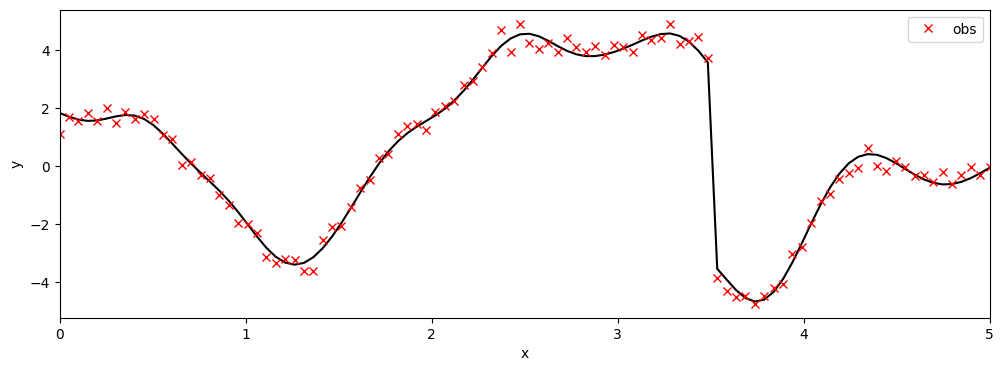

In [5]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.3
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
T = 5
x = jnp.linspace(0, T, n)[:, jnp.newaxis]

x0 = jnp.array([0.7])*T
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_,
                    alpha=T/len(x0))

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., T])
plt.legend();

In [ ]:
from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector
from jax.tree_util import tree_flatten, tree_unflatten


In [6]:
size = 20
base_kernel = jk.RBF()
kernel = Discontinuous_Poisson(base_kernel)
# p = jnp.zeros(num_CP+1)+(1/(num_CP+1))

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=1,
                                                               scale=1.2),
                                                     tfb.Exp())))

gp_marginal = FullMarginalGPModelhyper(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [7]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 47.5 s, sys: 33.4 s, total: 1min 20s
Wall time: 1min 22s


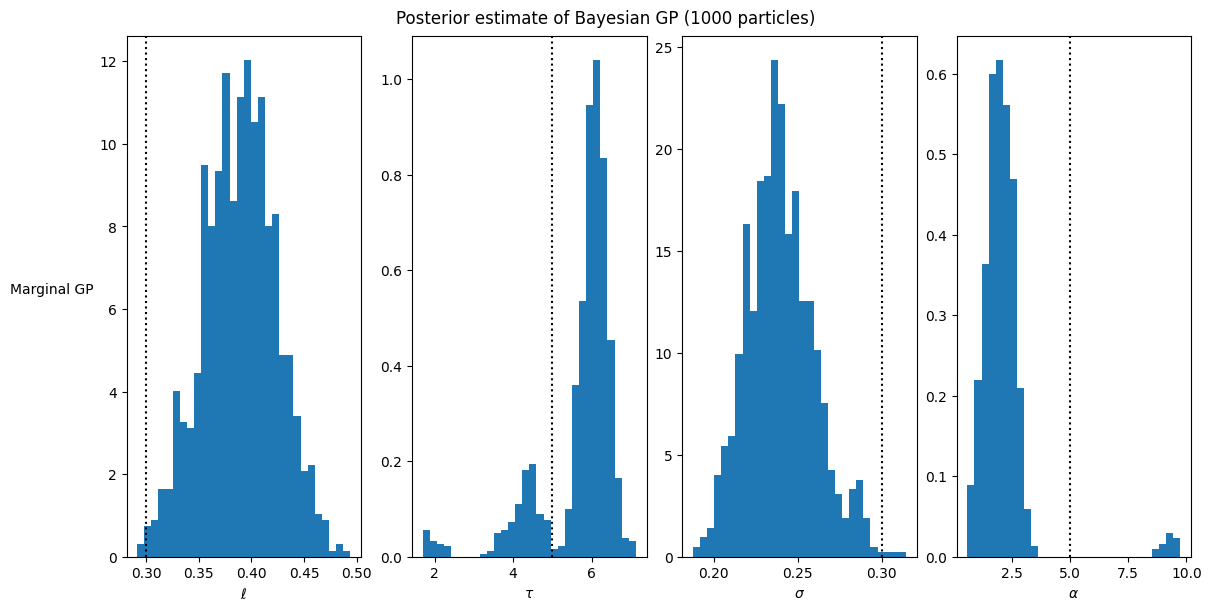

In [8]:
trainables = ['lengthscale', 'variance', 'obs_noise', 'alpha']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau',
               alpha=r'\alpha')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                    sharex="col", sharey=False, figsize=(12, 6))

particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
        variance=particles.particles['kernel']['variance'],
        obs_noise=particles.particles['likelihood']['obs_noise'],
        alpha=particles.particles['hyper']['hyper_pp'])
for j, var in enumerate(trainables):
    ax = axes[j]
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    ax.hist(pd, bins=30, density=True, color='tab:blue')
    ax.axvline(x=ground_truth[var], ls=':', c='k')
    if var in symbols:
        ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right')
plt.show()

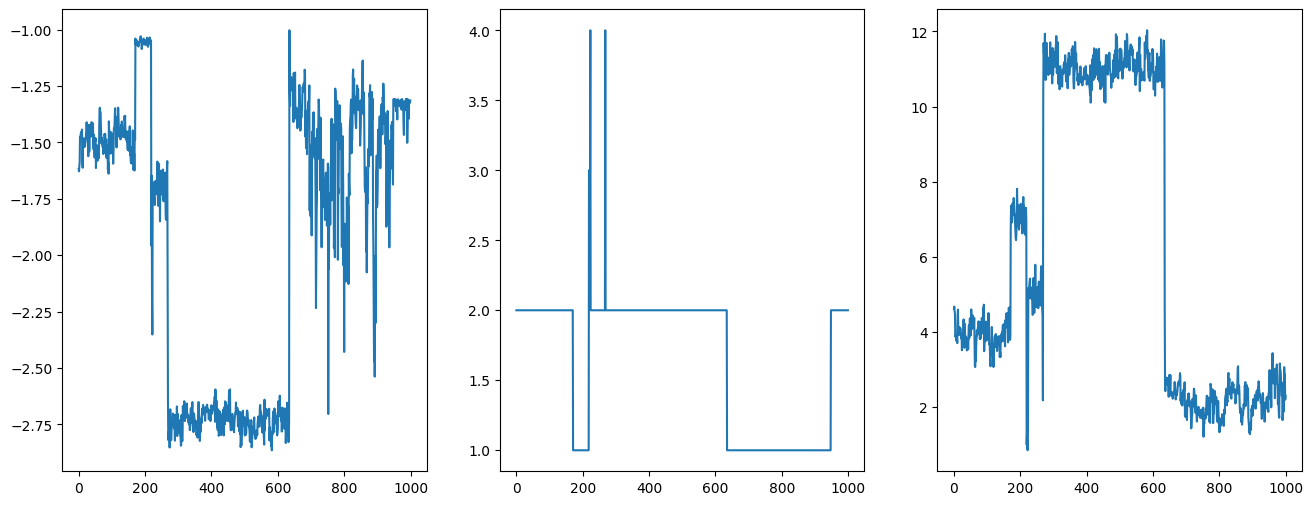

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (16, 6))

samples = gp_marginal.get_monte_carlo_samples()
PP = Poisson_Process_hyper(size, T)
log_probs = jnp.zeros(num_particles)
lengths = jnp.zeros(num_particles)
alphas = jnp.zeros(num_particles)

for i in range(num_particles):
  log_probs = log_probs.at[i].set(PP.log_prob(samples['kernel']['num'][i, :], samples['hyper']['hyper_pp'][i]))
  lengths = lengths.at[i].set(len(samples['kernel']['num'][i, ~jnp.isnan(samples['kernel']['num'][i, :])]))

axes[0].plot(log_probs)
axes[1].plot(lengths)
axes[2].plot(samples['hyper']['hyper_pp'])

Text(0, 0.5, 'Marginal GP')

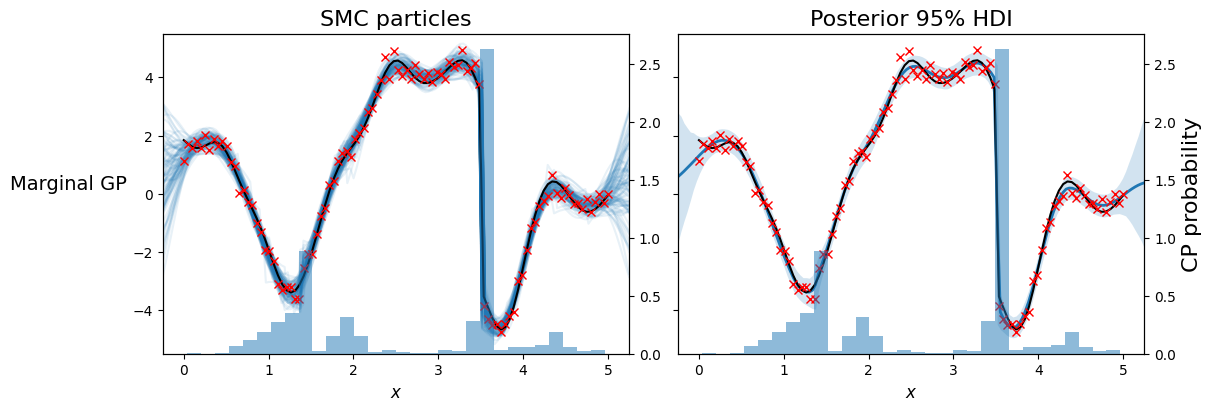

In [9]:
x_pred = jnp.linspace(-0.25, T+.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, T+.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

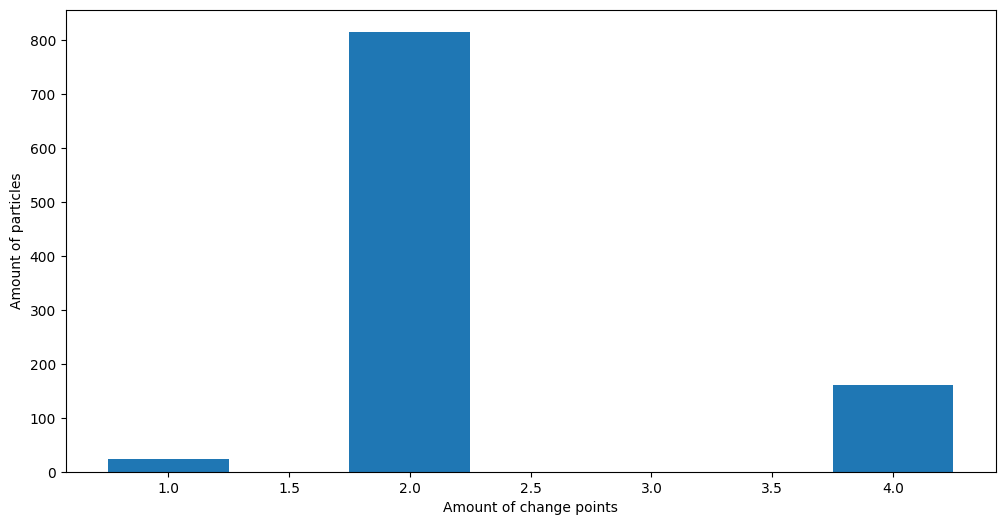

In [10]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

In [ ]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_unknown
from New_kernel_1 import Discontinuous_Dirichlet
from New_kernel_1 import Discontinuous_Poisson

from Poisson_Process import Poisson_Process

In [ ]:
scale = T/len(x0)
size = 20
base_kernel = jk.RBF()
kernel = Discontinuous_Poisson(base_kernel)
# p = jnp.zeros(num_CP+1)+(1/(num_CP+1))

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=Poisson_Process(scale, size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [ ]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 46.6 s, sys: 34 s, total: 1min 20s
Wall time: 1min 22s


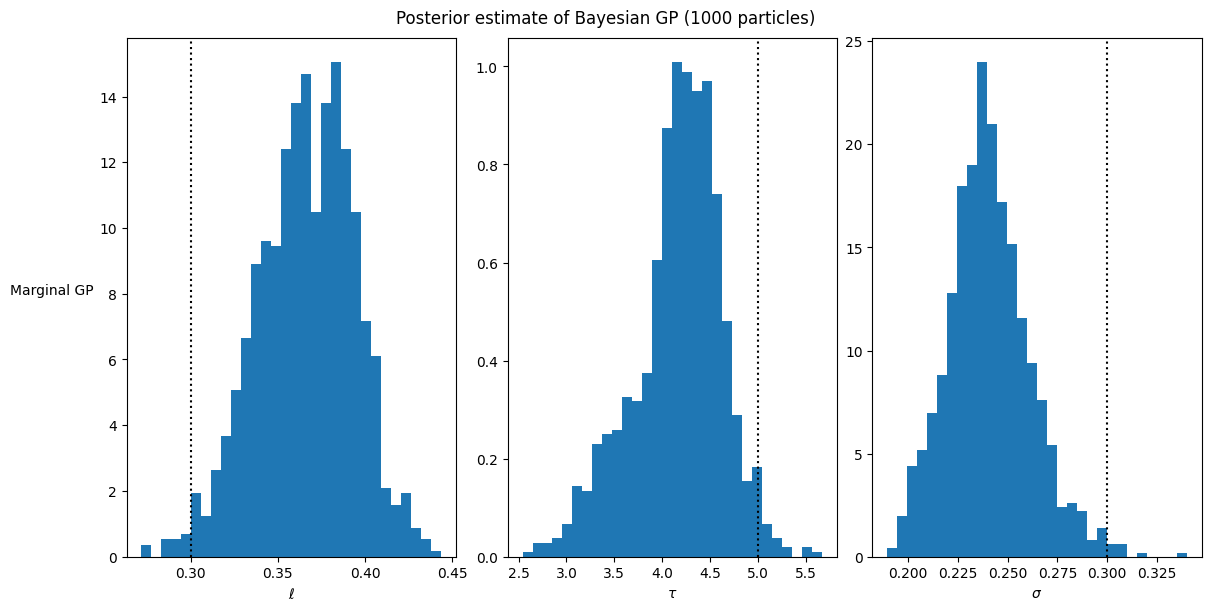

In [ ]:
trainables = ['lengthscale', 'variance', 'obs_noise']

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
            obs_noise='\sigma',
            variance=r'\tau',
               alpha=r'\alpha')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                    sharex="col", sharey=False, figsize=(12, 6))

particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
        variance=particles.particles['kernel']['variance'],
        obs_noise=particles.particles['likelihood']['obs_noise'])
for j, var in enumerate(trainables):
    ax = axes[j]
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    ax.hist(pd, bins=30, density=True, color='tab:blue')
    ax.axvline(x=ground_truth[var], ls=':', c='k')
    if var in symbols:
        ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right')
plt.show()

Text(0, 0.5, 'Marginal GP')

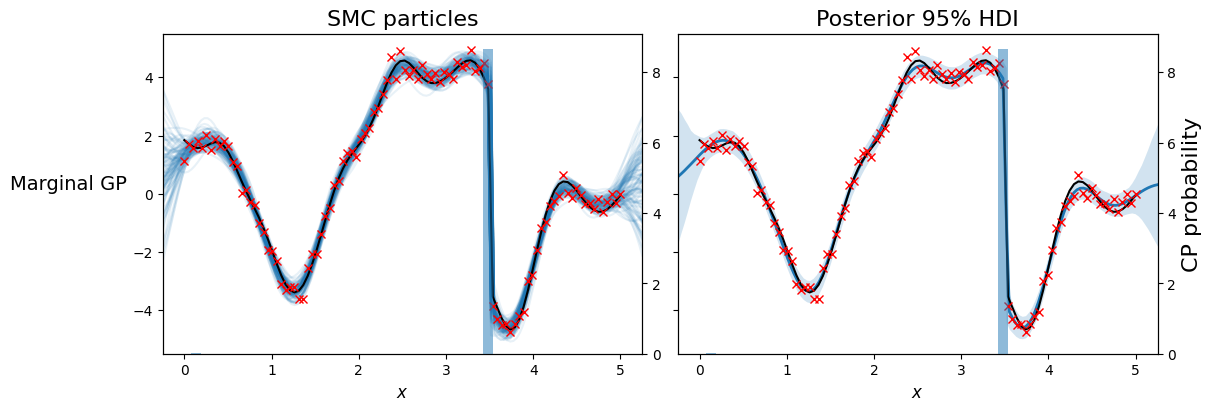

In [ ]:
x_pred = jnp.linspace(-0.25, T+.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, T+.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

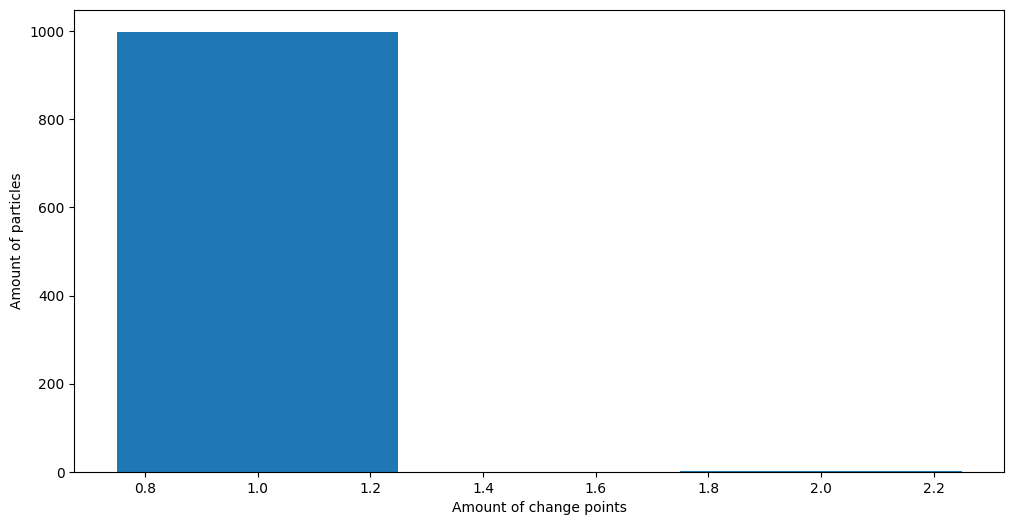

In [ ]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()